In [1]:
!pip install -q rasterio tensorflow

In [2]:
# Cell 2: Import Libraries
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Suppress TensorFlow warnings for a cleaner output
tf.get_logger().setLevel('ERROR')

print("Libraries imported successfully!")

2025-08-03 02:11:02.648295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754187062.672053     973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754187062.679304     973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!


In [3]:
# Cell 3: Define Constants and Mappings

# --- IMPORTANT: Update these paths to match your Kaggle input directory ---
BASE_IMAGE_PATH = '/kaggle/input/sample/Patch_3_Sentinel2_BaseImage_2021.tif' # Sentinel-2 Image
LULC_MASK_PATH = '/kaggle/input/sample/Patch_3_ESA_LULC_2021.tif'   # LULC Mask

# Mapping from ESA LULC pixel values to model-friendly indices (0, 1, 2...)
# These classes are based on the colors visible in your LULC image.
LULC_MAP = {
    10: 0,   # Tree cover
    20: 1,   # Shrubland
    30: 2,   # Grassland
    40: 3,   # Cropland
    50: 4,   # Built-up
    60: 5,   # Bare / sparse vegetation
    70: 6,   # Snow and ice
    80: 7,   # Permanent water bodies
    90: 8,   # Herbaceous wetland
    95: 9,   # Mangroves
    100: 10  # Moss and lichen
}

# Define the number of classes and the size of image patches for training
NUM_CLASSES = len(LULC_MAP)
PATCH_SIZE = 128

print(f"Number of classes defined: {NUM_CLASSES}")
print(f"Image patch size set to: {PATCH_SIZE}x{PATCH_SIZE}")

Number of classes defined: 11
Image patch size set to: 128x128


In [4]:
# Cell 4 (Corrected): Load, Remap, and Normalize Data

# 1. Load the base Sentinel-2 image
with rasterio.open(BASE_IMAGE_PATH) as src:
    base_image = src.read()
    base_image = np.transpose(base_image, (1, 2, 0))

# --- THE FIX IS HERE ---
# Replace any potential 'nan' values from the GeoTIFF with 0.
# This is critical to prevent 'nan' loss during training.
base_image = np.nan_to_num(base_image)
# --- END OF FIX ---

# 2. Load the LULC mask
with rasterio.open(LULC_MASK_PATH) as src:
    lulc_mask = src.read(1)

# 3. Remap the LULC mask to our sequential indices (0, 1, 2...)
ignore_value = NUM_CLASSES
remapped_mask = np.full(lulc_mask.shape, ignore_value, dtype=np.uint8)
for lulc_value, class_index in LULC_MAP.items():
    remapped_mask[lulc_mask == lulc_value] = class_index

# 4. One-hot encode the remapped mask
mask_one_hot = to_categorical(remapped_mask, num_classes=NUM_CLASSES + 1)

# 5. Normalize the base image
# For robustness, ensure the data type is float before division
base_image_normalized = base_image.astype(np.float32) / 4000.0
base_image_normalized = np.clip(base_image_normalized, 0, 1)

print(f"Base Image Shape: {base_image_normalized.shape}")
print(f"Original LULC Mask Shape: {lulc_mask.shape}")
print(f"One-Hot Encoded Mask Shape: {mask_one_hot.shape}")

Base Image Shape: (4458, 6680, 6)
Original LULC Mask Shape: (4457, 6680)
One-Hot Encoded Mask Shape: (4457, 6680, 12)


In [5]:
# Cell 5 (Corrected): Create Patches from Images

def create_patches(image, mask, patch_size, ignore_label_index, threshold=0.50): #<-- CHANGED
    """
    Extracts patches from a large image and its corresponding mask.
    It discards patches that contain more than the threshold of ignored pixels.
    """
    image_patches = []
    mask_patches = []
    
    height, width, _ = image.shape
    
    for y in range(0, height - patch_size + 1, patch_size):
        for x in range(0, width - patch_size + 1, patch_size):
            image_patch = image[y:y+patch_size, x:x+patch_size, :]
            mask_patch_with_ignore = mask[y:y+patch_size, x:x+patch_size, :]
            
            ignore_pixels = np.sum(mask_patch_with_ignore[:, :, ignore_label_index])
            total_pixels_in_patch = patch_size * patch_size
            
            # The threshold is now more lenient (0.5 instead of 0.95)
            if (ignore_pixels / total_pixels_in_patch) < threshold:
                valid_mask_patch = mask_patch_with_ignore[:, :, :-1]
                image_patches.append(image_patch)
                mask_patches.append(valid_mask_patch)
            
    return np.array(image_patches), np.array(mask_patches)

# The ignore label is the last channel, which has index NUM_CLASSES
ignore_index = NUM_CLASSES 
X, y = create_patches(base_image_normalized, mask_one_hot, PATCH_SIZE, ignore_index)

# This should now print a number greater than 0
print(f"Generated {len(X)} valid patches.")
print(f"Shape of X (image patches): {X.shape}")
print(f"Shape of y (mask patches): {y.shape}")

Generated 1768 valid patches.
Shape of X (image patches): (1768, 128, 128, 6)
Shape of y (mask patches): (1768, 128, 128, 11)


In [6]:
# Cell 6: Split Patches into Training and Testing Sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Training Image Patches: {X_train.shape}")
print(f"Training Mask Patches:  {y_train.shape}")
print(f"Testing Image Patches:  {X_test.shape}")
print(f"Testing Mask Patches:   {y_test.shape}")

Training Image Patches: (1414, 128, 128, 6)
Training Mask Patches:  (1414, 128, 128, 11)
Testing Image Patches:  (354, 128, 128, 6)
Testing Mask Patches:   (354, 128, 128, 11)


In [7]:
# Cell 7: Define and Build the U-Net Model

def build_unet(input_shape, num_classes):
    """
    Builds a U-Net model using the Keras Functional API.
    """
    inputs = Input(input_shape)

    # Encoder (Downsampling Path)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder (Upsampling Path) with skip connections
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Get input shape from our training data patches
INPUT_SHAPE = X_train.shape[1:]

# Build the model
# Remember, y_train's last dimension is NUM_CLASSES because we removed the 'ignore' channel
model = build_unet(INPUT_SHAPE, num_classes=y_train.shape[-1])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

I0000 00:00:1754187086.880191     973 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754187086.880865     973 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │      8,224 │ conv2d_9[0][0]  

 Total params: 482,635 (1.84 MB)

 Trainable params: 482,635 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import os
import datetime
import json
from tensorflow.keras.callbacks import ModelCheckpoint

# Define training parameters
EPOCHS = 10 # Or however many you want to run in this session
BATCH_SIZE = 32

checkpoint_path = "/kaggle/working/CNN.weights.h5"
progress_path = "/kaggle/working/train_progress.txt"
history_log_dir = "/kaggle/working/history_logs"
os.makedirs(history_log_dir, exist_ok=True)

# --- 1. Load Progress / Version ---
if os.path.exists(progress_path):
    with open(progress_path, "rt") as f:
        patch_version = int(f.read().strip()) + 1
else:
    patch_version = 1

print(f"\n=== Training Patch Batch Version: {patch_version} ===")
print(f"Start Time: {datetime.datetime.now().isoformat()}")

# --- 2. Show shape for this batch ---
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# --- 3. (re-)initialize model and (optional) load weights ---
model = build_unet(INPUT_SHAPE, num_classes=y_train.shape[-1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Checkpoint loaded.")

# --- 4. Callback ---
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# --- 5. Train ---
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_callback]
)

print(f"\nTraining finished for batch {patch_version} at {datetime.datetime.now().isoformat()}")

# --- 6. Save/Update Progress Version ---
with open(progress_path, "wt") as f:
    f.write(str(patch_version))

# --- 7. Save history log for each patch batch version ---
history_log_path = os.path.join(history_log_dir, f"history_patch{patch_version}.json")
with open(history_log_path, "wt") as f:
    json.dump(history.history, f)

print(f"Saved progress version and training history log for patch batch {patch_version}.")


=== Training Patch Batch Version: 3 ===
Start Time: 2025-08-03T02:11:27.803379
X_train shape: (1414, 128, 128, 6)
y_train shape: (1414, 128, 128, 11)
Checkpoint loaded.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)
I0000 00:00:1754187099.691174    1028 service.cc:148] XLA service 0x7a09400031d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754187099.691215    1028 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754187099.691221    1028 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754187100.388774    1028 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/45 ━━━━━━━━━━━━━━━━━━━━ 11:48 16s/step - accuracy: 0.0512 - loss: 4.3786

I0000 00:00:1754187108.449918    1028 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7411 - loss: 1.6910
Epoch 1: val_loss improved from inf to 0.47164, saving model to /kaggle/working/CNN.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 323ms/step - accuracy: 0.7434 - loss: 1.6771 - val_accuracy: 0.8779 - val_loss: 0.4716
Epoch 2/10
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8904 - loss: 0.4161
Epoch 2: val_loss improved from 0.47164 to 0.33327, saving model to /kaggle/working/CNN.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8907 - loss: 0.4145 - val_accuracy: 0.9011 - val_loss: 0.3333
Epoch 3/10
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9055 - loss: 0.3201
Epoch 3: val_loss improved from 0.33327 to 0.30270, saving model to /kaggle/working/CNN.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9057 - loss: 0.3193 - val_accuracy: 0.8960 - val_loss: 0.3027
Epoch 4/10
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9143 - loss: 0.2758
Epoch 4: val_loss improved 


Final Test Accuracy: 92.81%
Final Test Loss: 0.2064


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(1, 128, 128, 6))
  warnings.warn(msg)


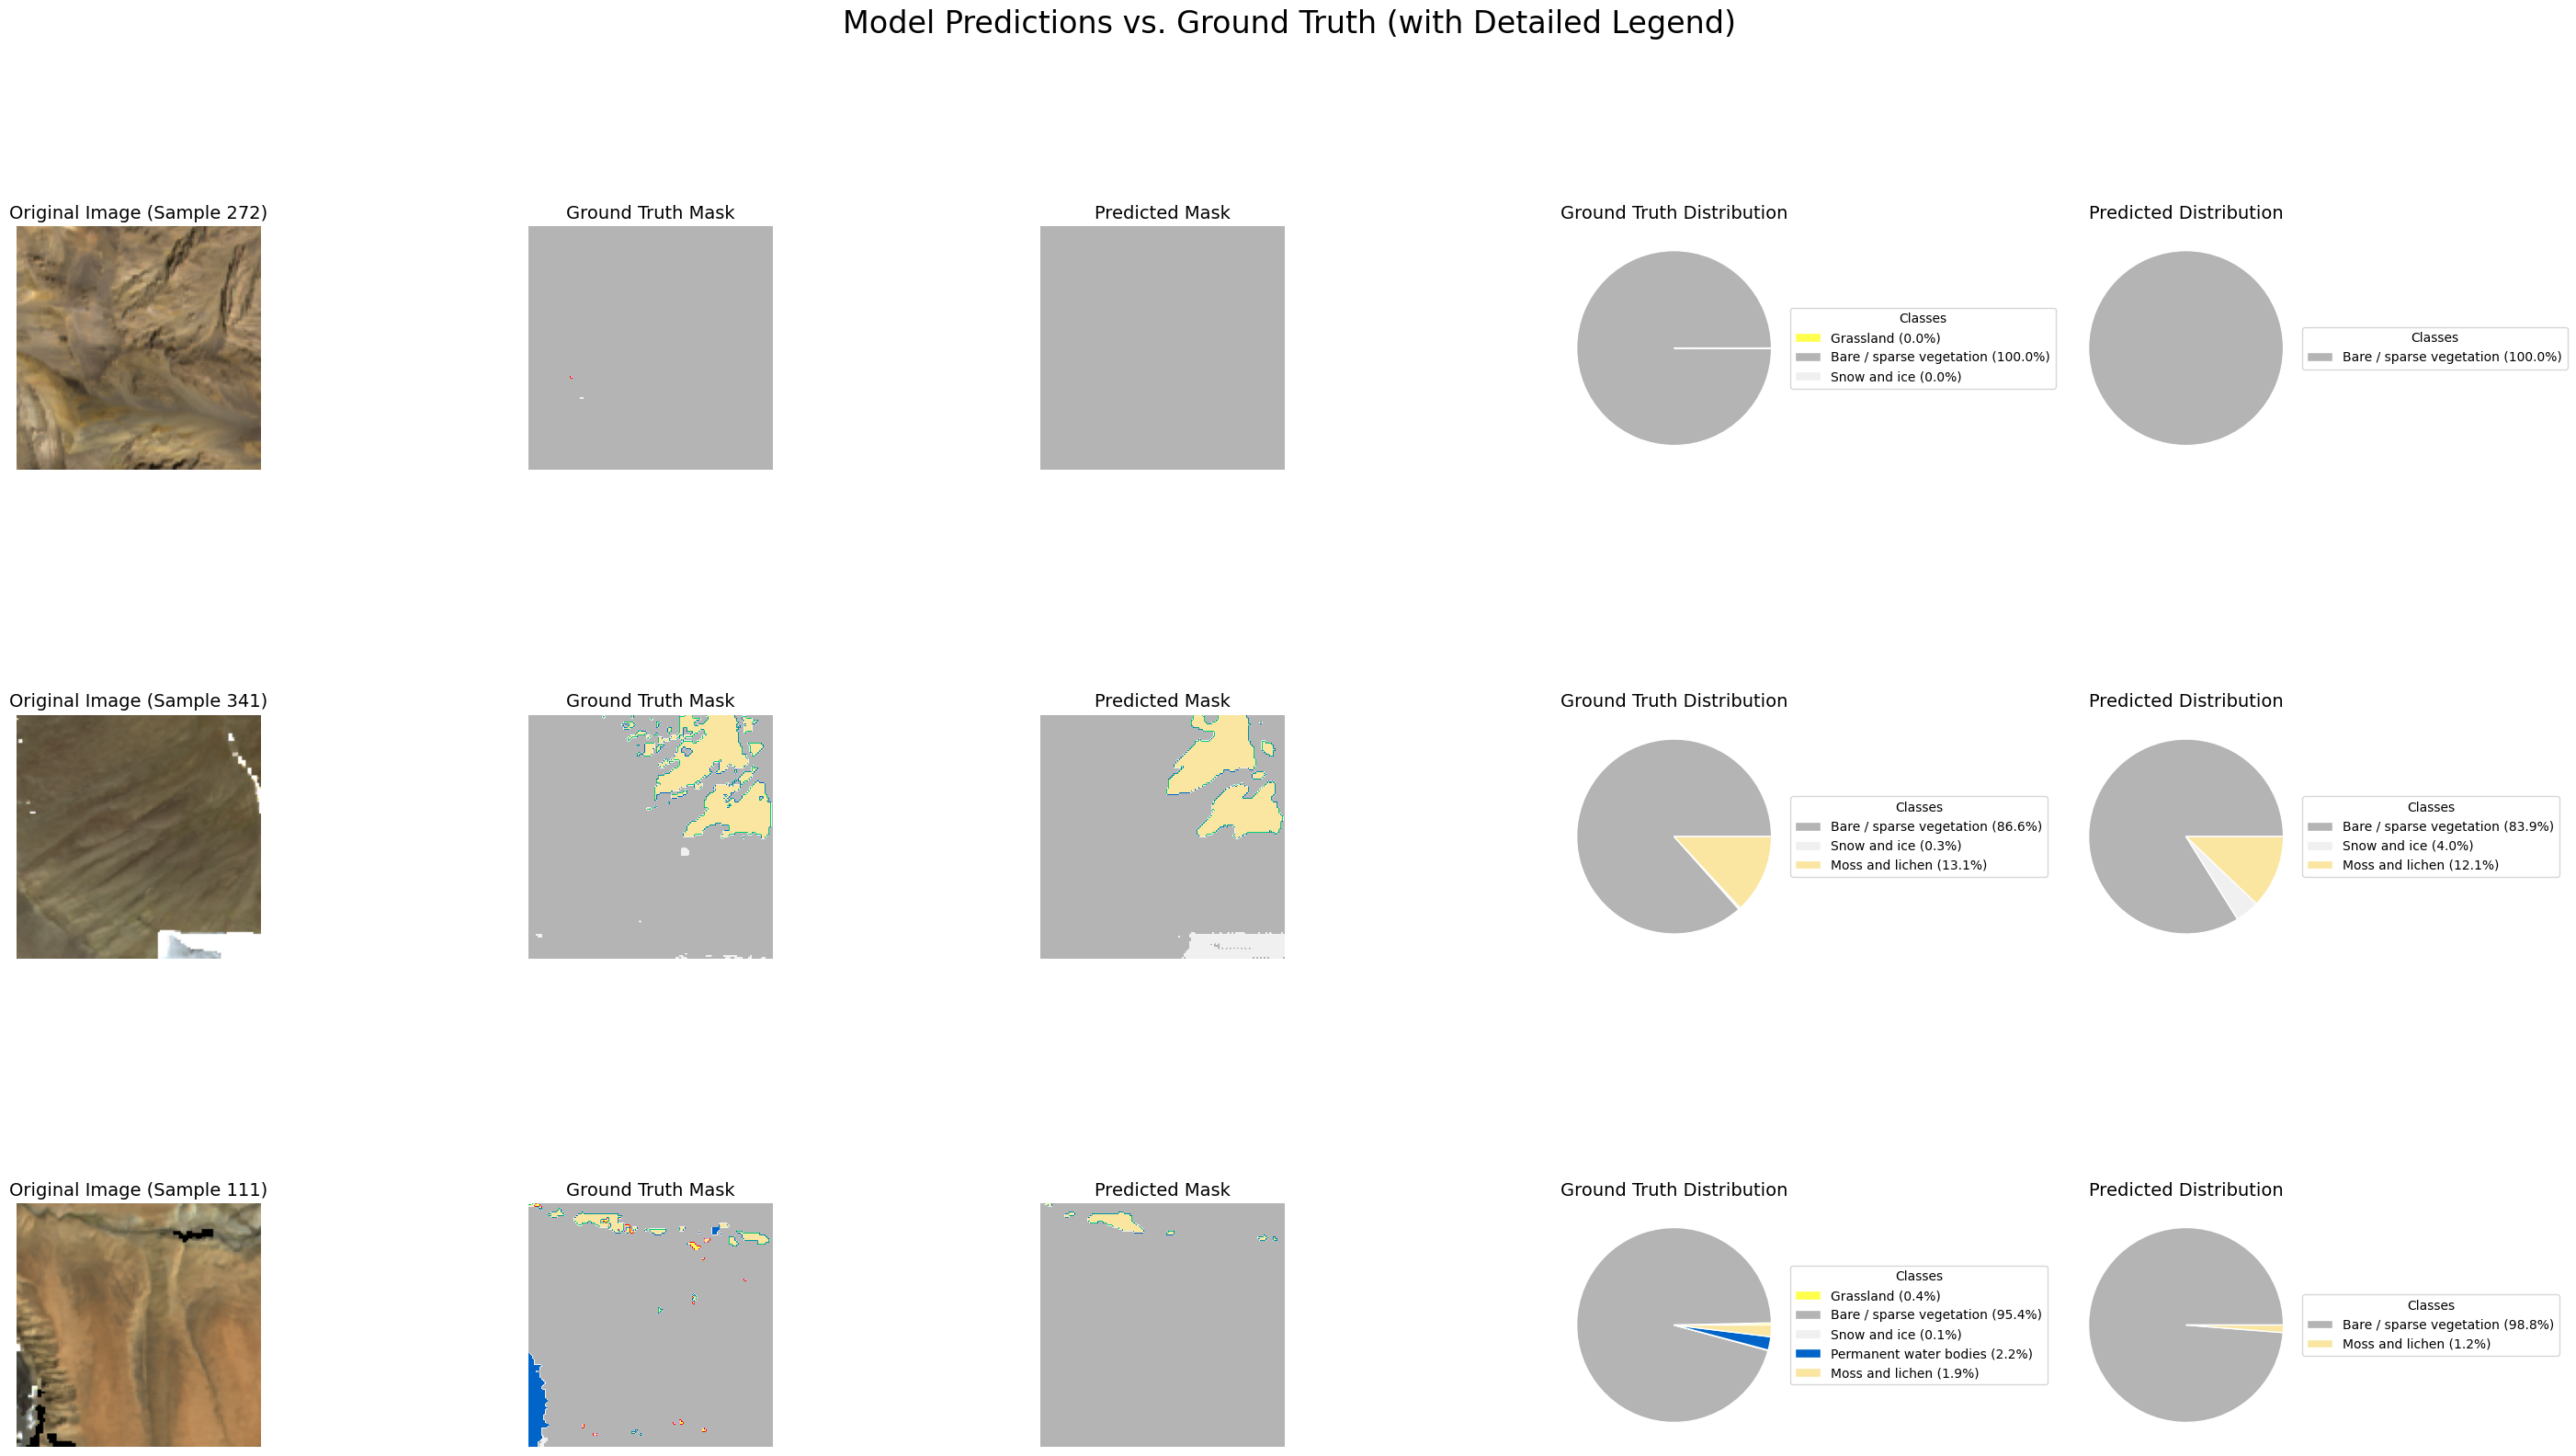

In [9]:
# Cell 9 (Final Version): Clean Pie with Detailed Legend

# 1. Evaluate the model on the entire test set for a final score
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")


# 2. Define class names and colors for visualization
CLASS_NAME_LIST = [
    'Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up',
    'Bare / sparse vegetation', 'Snow and ice', 'Permanent water bodies',
    'Herbaceous wetland', 'Mangroves', 'Moss and lichen'
]
VIS_COLORS = [
    '#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000', '#b4b4b4',
    '#f0f0f0', '#0064c8', '#0096a0', '#00cf75', '#fae6a0'
]
VIS_CMAP = plt.cm.colors.ListedColormap(VIS_COLORS)


# 3. Define the final visualization function
def visualize_clean_with_detailed_legend(num_samples=3):
    """
    Picks random samples and displays images and masks, with a clean pie chart
    and a detailed legend showing class percentages.
    """
    plt.figure(figsize=(28, 6 * num_samples))
    plt.suptitle("Model Predictions vs. Ground Truth (with Detailed Legend)", fontsize=24, y=0.95)

    for i in range(num_samples):
        # --- Image and Mask Preparation ---
        idx = np.random.randint(0, len(X_test))
        test_image = X_test[idx]
        true_mask = np.argmax(y_test[idx], axis=-1)
        predicted_mask_one_hot = model.predict(np.expand_dims(test_image, axis=0), verbose=0)[0]
        predicted_mask = np.argmax(predicted_mask_one_hot, axis=-1)

        # --- Plot 1, 2, 3: Original Image and Masks ---
        for j, (data, title) in enumerate([
            (test_image[:, :, [2, 1, 0]], f"Original Image (Sample {idx})"),
            (true_mask, "Ground Truth Mask"),
            (predicted_mask, "Predicted Mask")
        ]):
            ax = plt.subplot(num_samples, 5, i * 5 + j + 1)
            if j == 0:
                ax.imshow(data)
            else:
                ax.imshow(data, cmap=VIS_CMAP, vmin=0, vmax=len(CLASS_NAME_LIST)-1)
            ax.set_title(title, fontsize=14)
            ax.axis('off')

        # --- Plot 4: Ground Truth Pie Chart ---
        ax4 = plt.subplot(num_samples, 5, i * 5 + 4)
        ax4.set_title("Ground Truth Distribution", fontsize=14)
        class_indices, counts = np.unique(true_mask, return_counts=True)
        
        if len(class_indices) > 0:
            pie_colors = [VIS_COLORS[k] for k in class_indices]
            # Create legend labels with percentages included
            total_pixels = counts.sum()
            legend_labels = [f"{CLASS_NAME_LIST[k]} ({v/total_pixels*100:.1f}%)" for k, v in zip(class_indices, counts)]
            # Draw a clean pie chart with no text
            wedges, _ = ax4.pie(counts, colors=pie_colors, labels=None, autopct=None, wedgeprops={'edgecolor': 'white'})
            ax4.legend(wedges, legend_labels, title="Classes", loc="center left", bbox_to_anchor=(0.95, 0, 0.5, 1))

        # --- Plot 5: Predicted Pie Chart ---
        ax5 = plt.subplot(num_samples, 5, i * 5 + 5)
        ax5.set_title("Predicted Distribution", fontsize=14)
        class_indices, counts = np.unique(predicted_mask, return_counts=True)

        if len(class_indices) > 0:
            pie_colors = [VIS_COLORS[k] for k in class_indices]
            # Create legend labels with percentages included
            total_pixels = counts.sum()
            legend_labels = [f"{CLASS_NAME_LIST[k]} ({v/total_pixels*100:.1f}%)" for k, v in zip(class_indices, counts)]
            # Draw a clean pie chart with no text
            wedges, _ = ax5.pie(counts, colors=pie_colors, labels=None, autopct=None, wedgeprops={'edgecolor': 'white'})
            ax5.legend(wedges, legend_labels, title="Classes", loc="center left", bbox_to_anchor=(0.95, 0, 0.5, 1))

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


# 4. Call the final, polished visualization function
visualize_clean_with_detailed_legend(num_samples=3)

Running analysis on the entire test set... This may take a moment.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step

--- Class Distribution Analysis (Test Set) ---
Class Name                | Ground Truth (%)     | Predicted (%)  
---------------------------------------------------------------------------
Tree cover                |                0.02% |           0.00%
Shrubland                 |                0.00% |           0.00%
Grassland                 |                0.95% |           0.17%
Cropland                  |                0.00% |           0.00%
Built-up                  |                0.00% |           0.00%
Bare / sparse vegetation  |               87.57% |          90.51%
Snow and ice              |                4.79% |           4.47%
Permanent water bodies    |                2.09% |           1.61%
Herbaceous wetland        |                0.00% |           0.00%
Mangroves                 |                0.00% |           0.00%
Moss and lichen           |     

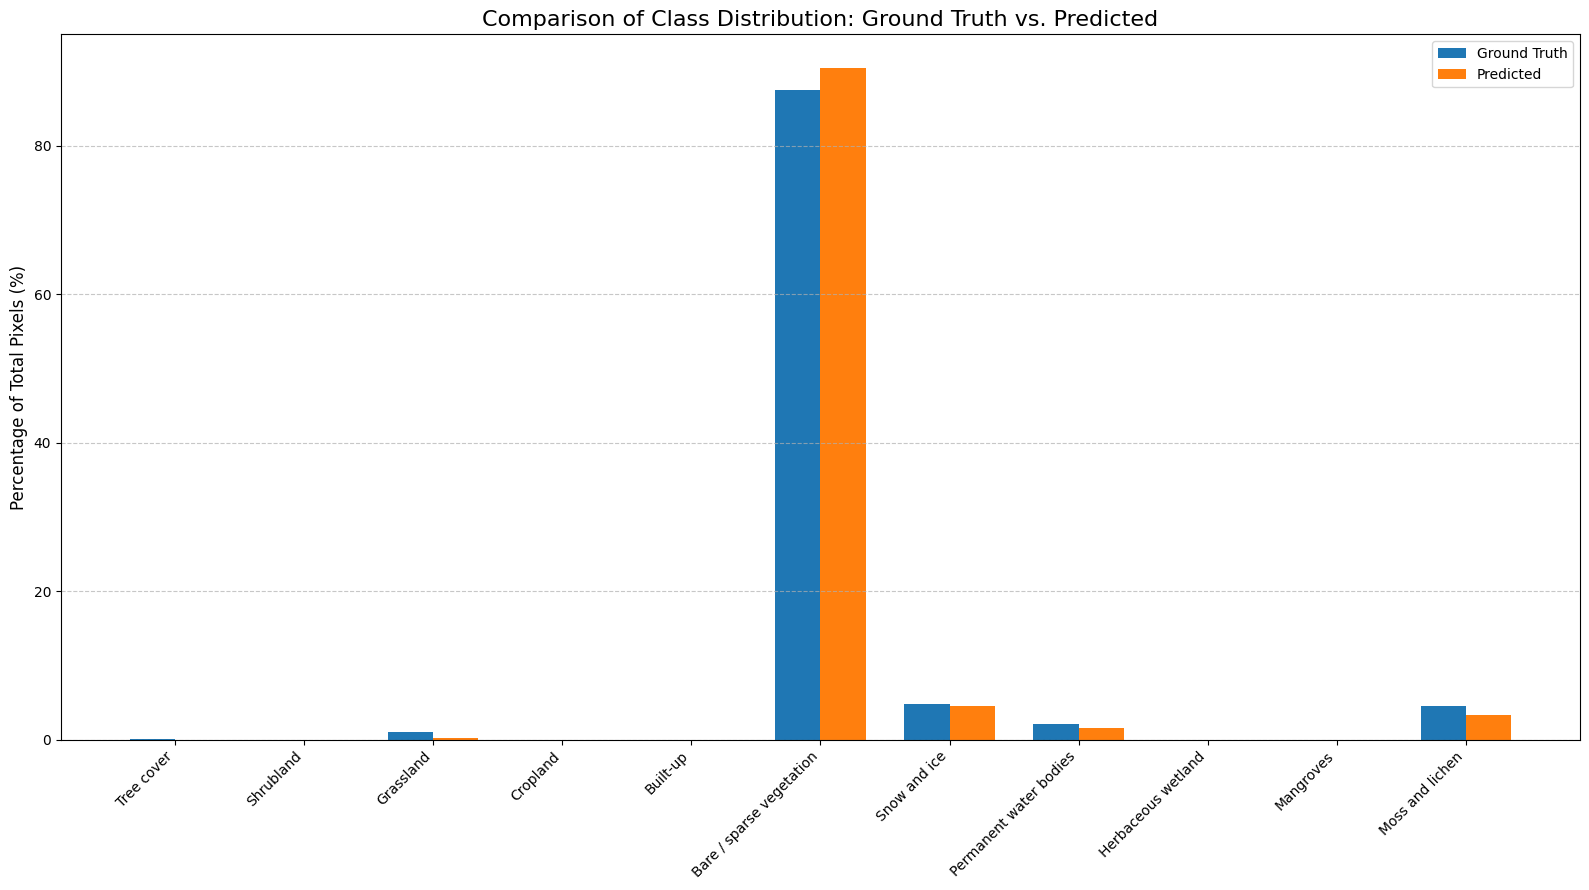

In [10]:
# Cell 10: Quantitative Class Distribution Analysis

print("Running analysis on the entire test set... This may take a moment.")

# 1. Get predictions for the entire test set
predicted_masks_one_hot = model.predict(X_test)
predicted_labels = np.argmax(predicted_masks_one_hot, axis=-1)

# Get the ground truth labels from the one-hot encoded y_test
true_labels = np.argmax(y_test, axis=-1)

# 2. Calculate the total number of pixels for percentage calculation
total_pixels = true_labels.size

# 3. Calculate pixel counts for each class in both true and predicted labels
true_class_indices, true_counts = np.unique(true_labels, return_counts=True)
true_distribution = dict(zip(true_class_indices, true_counts))

pred_class_indices, pred_counts = np.unique(predicted_labels, return_counts=True)
pred_distribution = dict(zip(pred_class_indices, pred_counts))

# 4. Print the results in a formatted table
# Create a list of class names for clear labeling
CLASS_NAME_LIST = [
    'Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up',
    'Bare / sparse vegetation', 'Snow and ice', 'Permanent water bodies',
    'Herbaceous wetland', 'Mangroves', 'Moss and lichen'
]

print("\n--- Class Distribution Analysis (Test Set) ---")
print(f"{'Class Name':<25} | {'Ground Truth (%)':<20} | {'Predicted (%)':<15}")
print("-" * 75)

# Prepare lists for the bar chart
true_percentages = []
pred_percentages = []

for i, class_name in enumerate(CLASS_NAME_LIST):
    # Get true percentage, using .get(i, 0) to handle classes not present in the test set
    true_p = (true_distribution.get(i, 0) / total_pixels) * 100
    true_percentages.append(true_p)
    
    # Get predicted percentage
    pred_p = (pred_distribution.get(i, 0) / total_pixels) * 100
    pred_percentages.append(pred_p)
    
    print(f"{class_name:<25} | {true_p: >19.2f}% | {pred_p: >14.2f}%")
print("-" * 75)


# 5. Visualize the distribution with a grouped bar chart for easier comparison
x = np.arange(len(CLASS_NAME_LIST))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 9))
rects1 = ax.bar(x - width/2, true_percentages, width, label='Ground Truth')
rects2 = ax.bar(x + width/2, pred_percentages, width, label='Predicted')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Percentage of Total Pixels (%)', fontsize=12)
ax.set_title('Comparison of Class Distribution: Ground Truth vs. Predicted', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAME_LIST, rotation=45, ha="right", fontsize=10)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.show()